In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt  #Graphics

### Load the data

Load the MNIST data set from two `.csv` files into two variables. 
Print the number of data points in the training and test sets.
Print the number of object in eacsh class.

In [2]:
train = pd.read_csv("data/mnist_train.csv")
test = pd.read_csv("data/mnist_test.csv")
print ("Training dataset has %i observations and %i variables" %(train.shape[0], train.shape[1]))
print ("Testing dataset has %i observations and %i variables" %(test.shape[0], test.shape[1]))


Training dataset has 59999 observations and 785 variables
Testing dataset has 9999 observations and 785 variables


### Slipt the data

Let us focus on the training data set. 
Split the 60000 observation into four equal-size random subsets, 
1. ${\cal D}_{train}$ to train the classifier,
2. ${\cal D}_{val}$ to train the localization function, 
3. ${\cal D}_{cal}$ to compute the quantiles,
4. ${\cal D}_{test}$ to evaluate the predictions sets.

We normalize the pixel values using the (column) means and standard deviations.

In [3]:
from sklearn.decomposition import PCA
dataset = train
df_x=dataset.iloc[:,1:].to_numpy(dtype=float)
df_x = (df_x - np.mean(df_x, axis = 0))/(1e-8 + np.std(df_x, axis = 0))
df_y = dataset.iloc[:, 0].to_numpy(dtype=int)
indexes = np.random.choice(len(df_x), len(df_x), replace=False)
stop = int(len(indexes)/4)
stops = [i * stop for i in range(5)]
X, y = [df_x[indexes[stops[i]:stops[i + 1]]] for i in range(4)], [df_y[indexes[stops[i] : stops[i + 1]]] for i in range(4)]

print("data set shapes:")
names = ['train', 'val', 'cal', 'test']
for ix in range(len(X)):
    print(names[ix], X[ix].shape, y[ix].shape)
    print(y[ix][0:5])
Xall, yall = X, y

data set shapes:
train (14999, 784) (14999,)
[9 3 6 1 5]
val (14999, 784) (14999,)
[0 5 4 8 4]
cal (14999, 784) (14999,)
[7 7 1 6 7]
test (14999, 784) (14999,)
[8 5 4 9 6]


### Train the classifier

Train a NN classifier on ${\cal D}_{train}$. 
The error rate on the four sets is resonable.

In [5]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(15, 15)) 
iset = 0
nn.fit(Xall[iset], yall[iset])
print(nn)
for iset in range(4):   
    probs = nn.predict_proba(Xall[iset])
    ER = 1 - sum([1 * (yall[iset][i] == np.argmax(probs[i])) for i in range(len(probs))])/len(probs)
    print(names[iset], "ER =", ER)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(15, 15), solver='lbfgs')
train ER = 0.0
val ER = 0.09213947596506433
cal ER = 0.08513900926728446
test ER = 0.08847256483765586


### Train the localizer

The goal is to train a model that minimizes
$$ {\rm E} |A - g(X)|^2$$
where $A = 1 - f_Y(X)$ and $f(X)\in [0, 1]^{10}$ is the output of the classifier.
It looks like this is hard.
I tried to add $f_0(X), \dots,  f_9(X)$ to the feature vector and to smoothen $A$ with an entropy term, e.g. $A \to A - \sum_{y} f_y(X) \log f_y(X)$.
Nothing seems to work.


C:\Users\ugqm002\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


val ER =  481.30717661384756
cal ER =  3385.2358242081314
test ER =  12423.184318228952


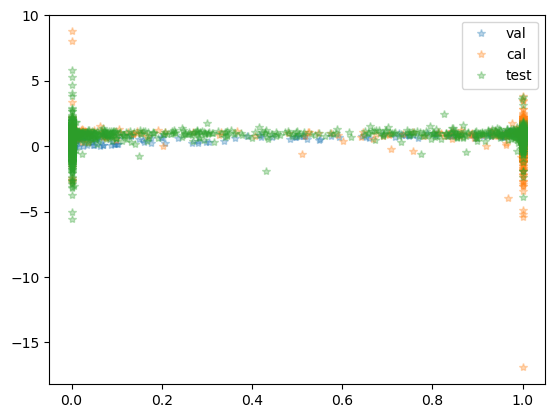

In [15]:
from sklearn.neural_network import MLPRegressor

def trainRegressor(z, a):
    g = MLPRegressor(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(15, 15))
    g.fit(z, a)
    return g

for iset in [1, 2, 3]:
    model = nn
    X = Xall[iset]
    probs = model.predict_proba(X)
    a = np.array([(1 - probs[i][Y[i]]) for i in range(len(y))])
    if (iset == 1):
        g = trainRegressor(X, a)
    aPredict = g.predict(X)
    ER = sum([(a[i] - aPredict[i])**2 for i in range(len(aPredict))])
    print(names[iset], "ER = ", ER)
    plt.plot(a, aPredict, '*', alpha = .3, label=names[iset])

plt.legend()              
plt.show()
